In [1]:
import pandas as pd
import numpy as np

In [2]:
from keras.models import model_from_json
# load json and create model
json_file = open('model_neural_network.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model_neural_network.h5")
print("Loaded model from disk")

Using TensorFlow backend.


Loaded model from disk


In [3]:
def load_data(date):
    
    def dummie_and_drop(df, name):
        # Creates a dummy variable, concatenates it and finally drops the original categorical variable.
        # In order not to have redundant variables, one of the dummy variables is dropped too
        dummies = pd.get_dummies(df[name]).rename(columns = lambda x: name + '_' + str(x))
        dummies = dummies.drop(dummies.columns[-1], axis = 1)
        df = pd.concat([df, dummies], axis = 1)
        df.drop(columns = [name], inplace=True, axis=1)

        return df
    
    def convert_to_categorical(df, categorical_variables, categories, need_pickup = True):
        """ 
        The dataframe's selected variables are converted to categorical, and each variable's categories are also specified.
        It is also specified if the "pickup community area" has to be converted into categorical or no. If it is not 
        converted into categorical it is because it's not going to be used in the model.            
        """
        
        if need_pickup:
            begin = 0
        else:
            df.drop(columns = ['pickup_community_area'], inplace = True, axis = 1)
            begin = 1
        
        for i in range(begin, len(categorical_variables)):
            df[categorical_variables[i]] = df[categorical_variables[i]].astype('category').cat.set_categories(categories[i])
        return df
    
    
    def load(name, date, need_pickup = False, drop_correlated = False):
    
        # This parameter has to be set to True if the "pickup_community_area" variable is needed in the model
        

        # Load needed dataset and choose the useful columns
        df = pd.read_csv(name) #'dataset_train.csv')
        df = df[df['trip_start_timestamp'].str.slice(start = 0, stop = 13) == date]
        x = df[['pickup_community_area' ,'temperature', 'relative_humidity', 'wind_direction', 'wind_speed', 'precipitation_cat', 
                'sky_level', 'daytype', 'Day Name', 'Month', 'Hour', 'Fare Last Month', 'Trips Last Hour',
                'Trips Last Week (Same Hour)', 'Trips 2 Weeks Ago (Same Hour)', 'Quarter', 'Year', 'trip_start_timestamp']]

        # Convert the categorical variables
        categorical_variables = ['pickup_community_area', 'daytype', 'sky_level', 'Day Name', 'Month','Hour', 'Year']
        categories = [[*(range(1,78))], ['U', 'W', 'A'], ['OVC', 'BKN', 'SCT', 'FEW', 'CLR', 'VV '], 
                      ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
                      [*(range(1,13))], [*(range(0, 24))], ['2017', '2018', '2019']]

        x = convert_to_categorical(x, categorical_variables, categories, need_pickup = need_pickup)

        
        # Make dummy variables with the categorical ones
        if need_pickup:
            begin = 0
        else:
            begin = 1
        for i in range(begin, len(categorical_variables)):
            x = dummie_and_drop(x, name = categorical_variables[i])
        
        
        
        y = df['Trips'].to_numpy()

        if need_pickup == False:
            # If we don't need the pickup, it means this is Neural Network case. Therefore we have to modify Y, in order
            # to have "n_areas" outputs per input (because there are "n_areas" regressions per input)
            x = x.groupby(by = 'trip_start_timestamp').mean()
            n_areas = 77
            y = np.reshape(y, [-1, n_areas]) # If 
        else:
            x.drop(columns = ['trip_start_timestamp'], inplace = True, axis = 1)
        
        if drop_correlated:
            x.drop(columns = ['Trips Last Week (Same Hour)'], inplace = True, axis = 1)
            x.drop(columns = ['Trips 2 Weeks Ago (Same Hour)'], inplace = True, axis = 1)

        x = x.to_numpy()
        
        return (x,y)   
    

    need_pickup = False 
    drop_correlated = False
    

    name_test = 'dataset_test.csv'
    x_test, y_test = load(name_test, date, need_pickup, drop_correlated)
    
    
    return (x_test, y_test)

In [4]:
def calculateDisposition(date, date_test, df_taxi):
    
    # Take only the columns needed
    df_taxi = df_taxi[['taxi_id', 'trip_end_timestamp','dropoff_community_area', 'trip_start_timestamp']]
    df_busy = df_taxi[df_taxi['trip_start_timestamp'].str.slice(start = 0, stop = 13) == date]
    df_arrive = df_taxi[(df_taxi['trip_start_timestamp'].str.slice(start = 0, stop = 16) == date_test + ':00') | (df_taxi['trip_start_timestamp'].str.slice(start = 0, stop = 16) == date_test + ':15')]
    df_date = df_taxi[df_taxi['trip_end_timestamp'].str.slice(start = 0, stop = 13) == date]
    df_date = df_date.sort_values(by = ['trip_end_timestamp'])
    
    
    print('number of trips: ', df_date.shape[0])
    print('number of different taxis: ', len(df_date['taxi_id'].unique()))
    print('number of missing values: ', sum(df_date['dropoff_community_area'].isnull())) # Even if it is null, in a real case we would have the data
    print()
    print('------ Deleting missing values ------')
    df_date = df_date.dropna()
    print()
    print('number of trips: ', df_date.shape[0])
    print('number of different taxis: ', len(df_date['taxi_id'].unique()))
    print('number of missing values: ', sum(df_date['dropoff_community_area'].isnull()))
    print()
    print('------ Deleting duplicated values ------')
    print()
    df_date.drop_duplicates(subset = 'taxi_id', keep = 'last', inplace = True)
    print('number of trips: ', df_date.shape[0])
    print('number of different taxis: ', len(df_date['taxi_id'].unique()))
    print('number of missing values: ', sum(df_date['dropoff_community_area'].isnull()))
    
    
    df_busy.drop_duplicates(subset = 'taxi_id', keep = 'last', inplace = True)
    
    
    index_delete = []

    for i in range(0, len(df_date)):
        taxi = df_date[['taxi_id', 'trip_end_timestamp']].iloc[i]
        for j in range(0, len(df_busy)):
            taxi_busy = df_busy[['taxi_id', 'trip_start_timestamp']].iloc[j]
            if (str(taxi_busy['taxi_id']) == str(taxi['taxi_id']) and (str(taxi_busy['trip_start_timestamp']) >= str(taxi['trip_end_timestamp']))):
                index = taxi.name
                index_delete.append(index)
                break
    df_date.drop(index_delete, inplace = True)
    
    df_arrive.dropna(inplace = True)
    df_arrive.drop_duplicates(subset = 'taxi_id', keep = 'first', inplace = True)
    
    print('Ammount of taxis not moving: ', df_date['dropoff_community_area'].shape[0])
    print('Ammount of taxis arriving: ', df_arrive['dropoff_community_area'].shape[0])
    # df_total = pd.concat([df_date, df_arrive])


    count_not_moving = df_date.groupby(by = 'dropoff_community_area').count()
    count_arriving = df_arrive.groupby(by = 'dropoff_community_area').count()

    count_not_moving = count_not_moving.reindex(range(1,78), fill_value = 0)
    count_arriving = count_arriving.reindex(range(1,78), fill_value = 0)


    x_not_moving = count_not_moving['taxi_id'].to_numpy()
    x_arriving = count_arriving['taxi_id'].to_numpy()
    
    return (x_not_moving, x_arriving)

    
    

In [5]:
df_taxi = pd.read_csv('may-nov19.csv')

In [64]:
date = '2019-11-09 12'
date_test = '2019-11-09 13' # The next hour



x_test, y_test = load_data(date_test)
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.evaluate(x_test, y_test)
y_pred = model.predict(x_test)
# model.compile(optimizer = 'adam', loss = 'mse')
print('predicted demand: ', np.sum(y_pred))
print('real demand: ', np.sum(y_test))


1/1 [==============================] - 0s 20ms/step
predicted demand:  210.4578
real demand:  205


C:\Programs_julen\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Programs_julen\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [65]:
x_not_moving, x_arriving = calculateDisposition(date, date_test, df_taxi)

number of trips:  294
number of different taxis:  184
number of missing values:  32

------ Deleting missing values ------

number of trips:  262
number of different taxis:  163
number of missing values:  0

------ Deleting duplicated values ------

number of trips:  163
number of different taxis:  163
number of missing values:  0


C:\Programs_julen\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Ammount of taxis not moving:  109
Ammount of taxis arriving:  100


C:\Programs_julen\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Programs_julen\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [66]:
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 21ms/step


[2.4578897953033447, 0.8566052317619324]

In [67]:
Y = model.predict(x_test)
Y = Y.clip(min = 0)
result = np.round(Y).astype('int')
result

array([[ 2,  3,  4,  2,  2, 14,  9, 73,  0,  0,  1,  0,  0,  1,  1,  2,
         0,  0,  0,  0,  1,  3,  0,  5,  0,  0,  0, 18,  0,  0,  0, 34,
         4,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 16,  4]])

# Representation in Map

In [68]:
import os, sys
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import importlib.util
import joblib

# Get current path from where script is executed
if os.name == 'nt':
    sep = '\\'
elif os.name == 'posix':
    sep = '/'
else:
    print(f'What is this OS? {os.name}')

path = os.getcwd()
pathToSrc =  path[:path.find('srDataSets')+10]
pathToGDrive =  path[:path.find('Code')]
path_datasets = pathToGDrive + f'DataSets{sep}'

pathToDataSet = pathToGDrive + f'DataSets{sep}' + 'dataset_final.csv'
df = pd.read_csv(pathToDataSet)


#MapGenerator Lib
path_maps = path + f'{sep}mapGeneration{sep}mapGeneration.py'
spec = importlib.util.spec_from_file_location("mapGeneration", path_maps)
mp = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mp)

In [69]:
print(y_test)
print(result)

[[ 1  1  6  5  4 12  4 71  0  1  0  0  4  2  1  2  0  0  2  1  0  3  0  4
   1  0  1 16  0  0  1 25  3  0  0  0  0  0  0  1  1  3  1  2  0  1  0  0
   1  0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  1  1  0  0  0  0
   2  0  0 14  4]]
[[ 2  3  4  2  2 14  9 73  0  0  1  0  0  1  1  2  0  0  0  0  1  3  0  5
   0  0  0 18  0  0  0 34  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0 16  4]]


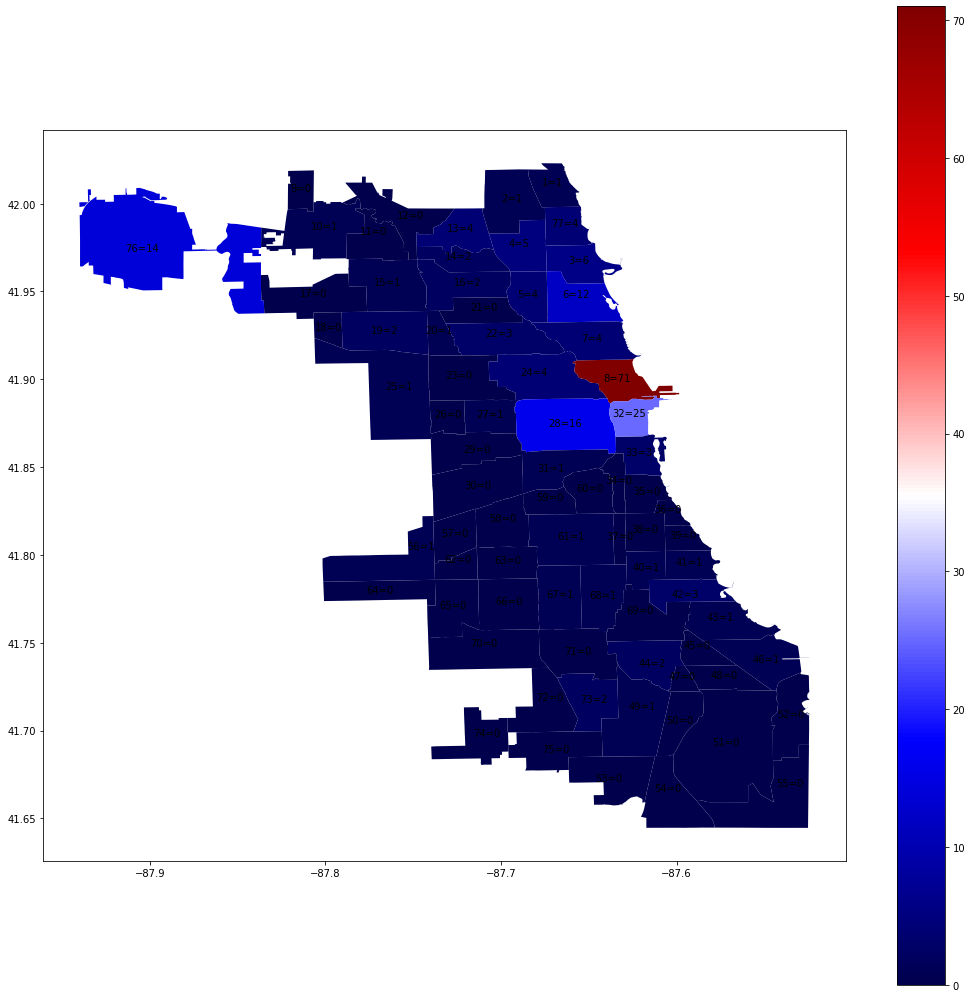

total real demand: 205


In [70]:
mp.mapGenerator(y_test)
print('total real demand:', np.sum(y_test))

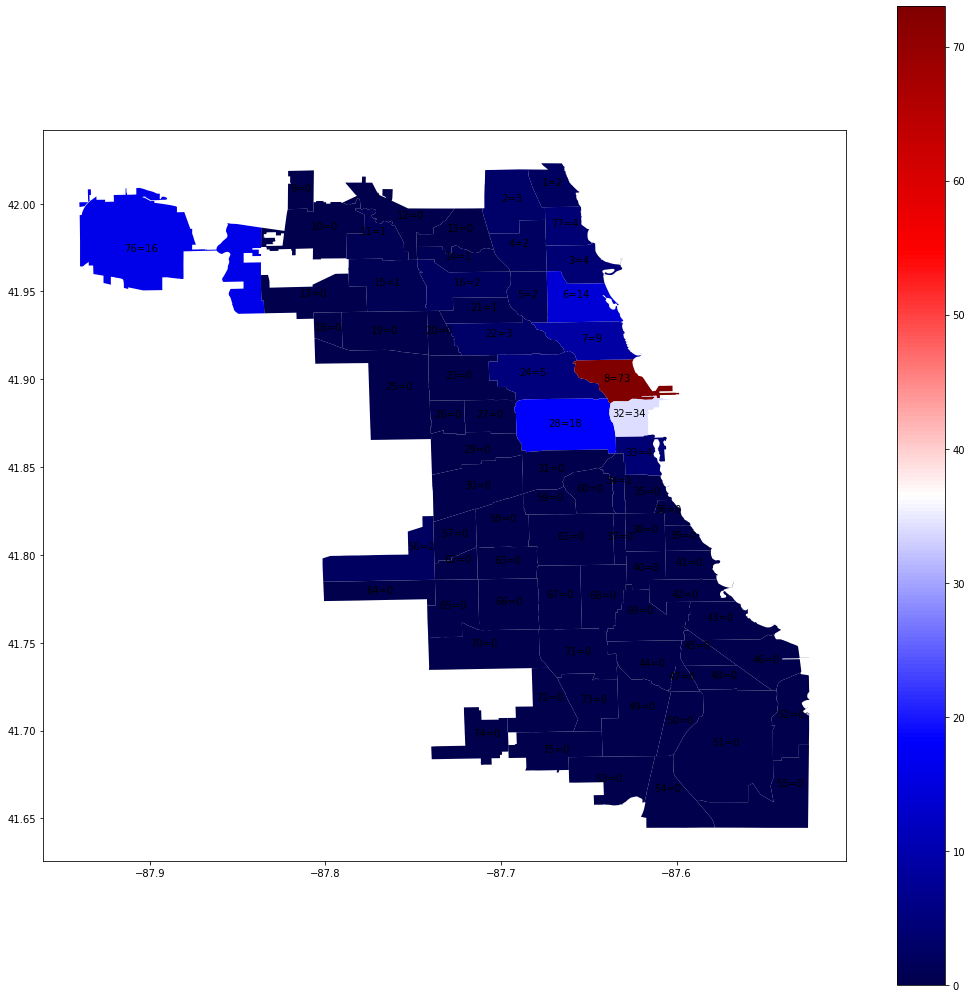

total predicted demand: 202


In [71]:
mp.mapGenerator(result)
print('total predicted demand:', np.sum(result))

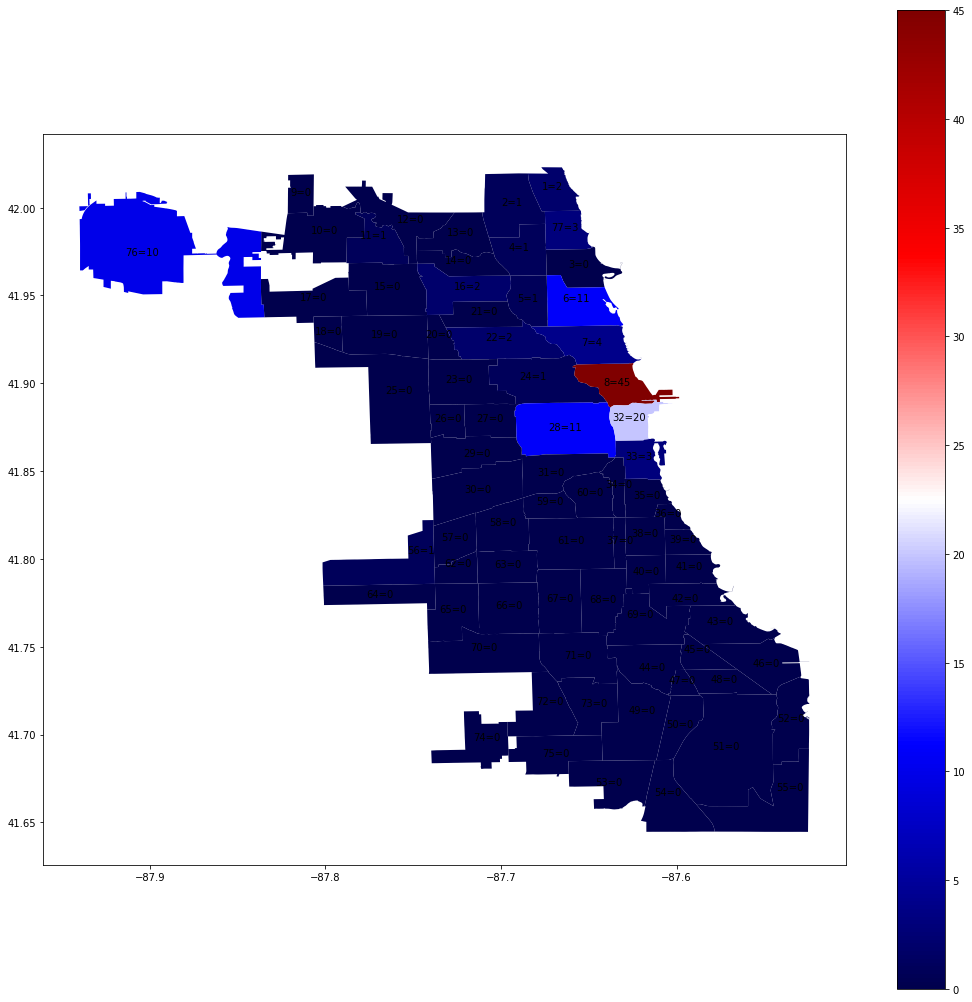

total predicted demand: 119


In [72]:
# Map of the demand we have to supply
y_new = ((result - x_arriving)).clip(min = 0)
mp.mapGenerator(y_new)
print('total predicted demand:', np.sum(y_new))

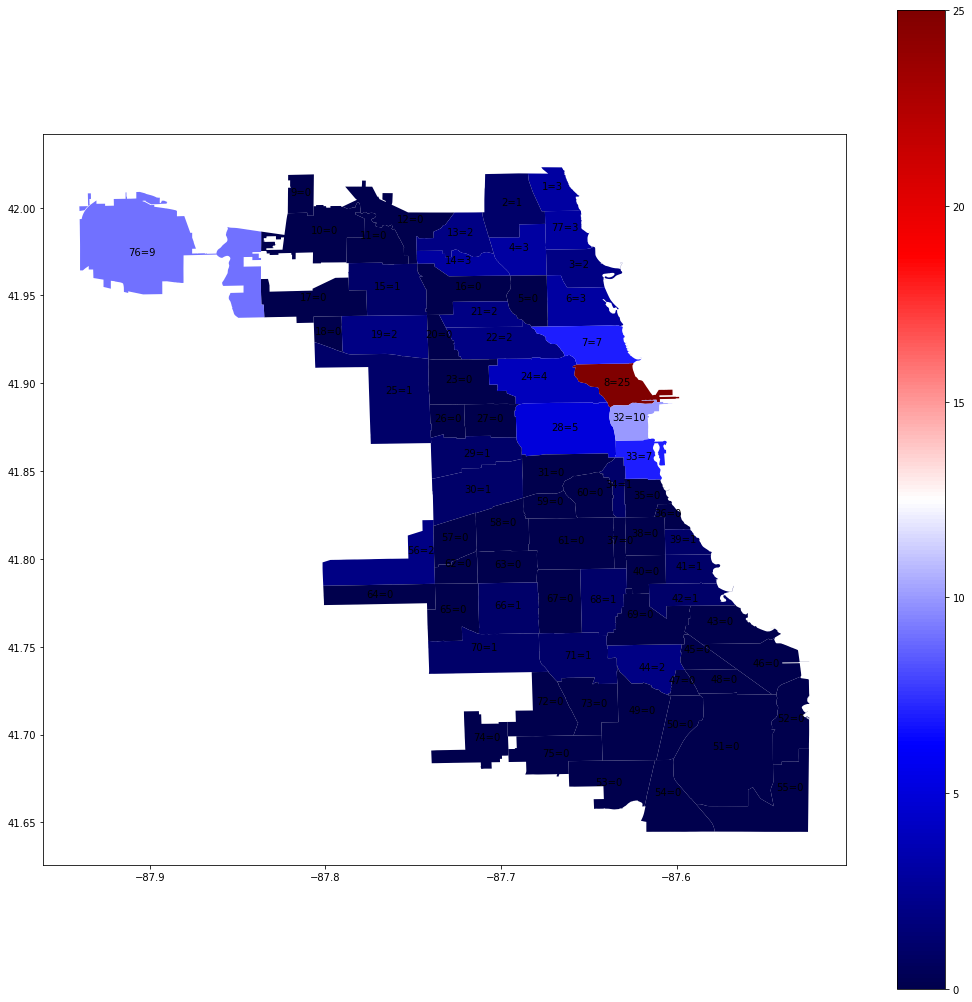

total available taxis: 109


In [76]:

mp.mapGenerator(x_not_moving)
print('total available taxis:', np.sum(x_not_moving))

In [74]:
# Suposicion: si no hacemos nada, los taxis se quedan como estan, quietos, misma community area
# tiempo -> dinero ?
# 
# Movements: - 6 taxis from 33 to 8
#            - 
#   
#

In [75]:
# # Test
# date = "2019-11-12 15:00:00"
# X = neuralNet.TransformDataToX(df, date)
# print(X)
# print(X.shape)
# # Predict
# Y = model_neural_network.predict(X)
# prediction = neuralNet.TransformYToResult(Y)
# mp.mapGenerator(prediction)

In [79]:
redistribution = np.zeros((1,77))

In [80]:
redistribution.shape

(1, 77)

In [88]:
redistribution[0][33 -1] = -6
redistribution[0][7 -1] = -3
redistribution[0][24 -1] = -3
redistribution[0][30 -1] = -1
redistribution[0][29 -1] = -1
redistribution[0][13 -1] = -2
redistribution[0][14 -1] = -2
redistribution[0][19 -1] = -2

redistribution[0][8 -1] = 6 + 3 + 3 + 2 +2 +2
redistribution[0][28 -1] = 2

In [89]:
redistribution

array([[ 0.,  0.,  0.,  0.,  0.,  0., -3., 18., 18.,  0.,  0.,  0., -2.,
        -2., -2.,  0.,  0.,  0., -2., -2.,  0.,  0.,  0., -3., -3.,  0.,
         0.,  2., -1., -1., -1.,  0., -6., -6.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

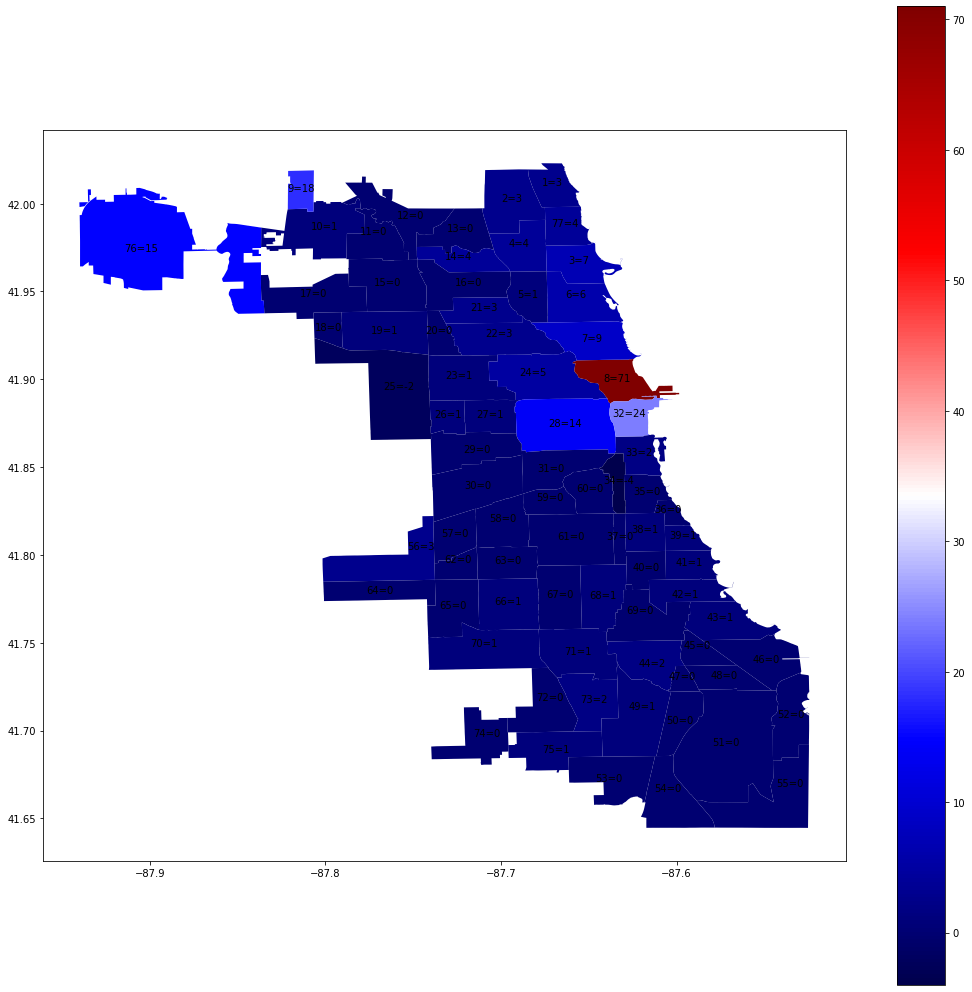

In [92]:
red_final = redistribution + x_not_moving + x_arriving
mp.mapGenerator(red_final.astype('int'))

# Profit calculation

In [102]:
times = pd.read_csv('commAreasTime.csv')
times.drop(['pickup_community_area'], axis = 1, inplace = True)
t1 = times.iloc[33, 8]
t2 = times.iloc[33, 32]
t3 = times.iloc[7, 8]
t4 = times.iloc[24, 8]
t5 = times.iloc[30, 28]
t6 = times.iloc[29, 28]
t7 = times.iloc[13, 8]
t8 = times.iloc[14, 8]
t9 = times.iloc[19, 8]

In [104]:
time_won = 2*t1 + 1*t2 - 2*t2 + 3*t3 + 3*t4 + 1*t5 + 1*t6 + 2*t8 + 1*t9

228.7376317335958

In [105]:
total_demand = np.sum(y_test)
taxi_minutes = total_demand * 60

In [107]:
time_won / taxi_minutes * 100

1.8596555425495593

In [110]:
# Better approach: total money
# Lets assume 14$/hour
print('the amount of money profit per hour:', time_won/60 * 14)
print('the amount of money profit per day:', time_won/60 * 14 * 24)
print('the amount of money profit per year:', time_won/60 * 14 * 24 * 365)

the amount of money profit per hour: 53.372114071172355
the amount of money profit per day: 1280.9307377081366
the amount of money profit per year: 467539.71926346986
